In [3]:
from fenics import *
from mshr import *
from dolfin import *
import matplotlib.pyplot as plt
from ISHE_constants_Bi2Se3_variable import *

In [13]:
import dijitso

In [66]:
print(dijitso.__version__)

2019.1.0


In [15]:
set_log_level(20)

In [16]:
width = 100.0
height = 5.0

In [17]:
# Read mesh from file
rectangle = Rectangle(Point(0, 0), Point(100.0, 5.0))
mesh = generate_mesh(rectangle, 500)
# mesh = UnitSquareMesh(50, 50)

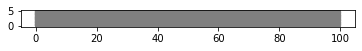

In [18]:
plot(mesh)

In [19]:
# Define function space for system of concentrations
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1, P1])
V_space = FunctionSpace(mesh, element)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [20]:
# Define test functions
v_1, v_2, v_3 = TestFunctions(V_space)

In [21]:
# Define functions for f amd g
u = Function(V_space)

# Split system functions to access components
n, p, V = split(u)
# f, g, h = split(u)

In [22]:
# Define boundaries
right   = f'near(x[0], {height})'
left    = 'near(x[0], 0.0)'

# Define boundary conditions
"""
Boundary Conditions For n
"""
# bc_n_left  = n_i * exp((Eg0_e/2 - Vbh_l)/kBT_e)
# bc_n_right = n_i * exp((Eg0_e/2 - Vbh_r)/kBT_e)


bc_n_left_expr = Expression("n_i * exp((Eg0_e/2 - Vbh_l)/kBT_e)",
                                   n_i=n_i, Eg0_e=Eg0_e, Vbh_l=Vbh_l, kBT_e=kBT_e,
                                   degree=0)
bc_n_right_expr = Expression("n_i * exp((Eg0_e/2 - Vbh_r)/kBT_e)", \
                                   n_i=n_i, Eg0_e=Eg0_e, Vbh_r=Vbh_r, kBT_e=kBT_e, \
                                   degree=0)
bc_n_left   = DirichletBC(V_space.sub(0), bc_n_left_expr, left)
bc_n_right  = DirichletBC(V_space.sub(0), bc_n_right_expr, right)


"""
Boundary Conditions For p
"""
# bc_p_left  = n_i * exp(-(Eg0_e/2 - Vbh_r) / kBT_e)
# bc_p_right = n_i * exp(-(Eg0_e/2 - Vbh_l) / kBT_e)
bc_p_left_expr = Expression("n_i * exp(-(Eg0_e/2 - Vbh_l)/kBT_e)", \
                                   n_i=n_i, Eg0_e=Eg0_e, Vbh_l=Vbh_l, kBT_e=kBT_e, \
                                   degree=0)

bc_p_right_expr = Expression("n_i * exp(-(Eg0_e/2 - Vbh_r)/kBT_e)", \
                                   n_i=n_i, Eg0_e=Eg0_e, Vbh_r=Vbh_r, kBT_e=kBT_e, \
                                   degree=0)
bc_p_left   = DirichletBC(V_space.sub(1), bc_p_left_expr, left)
bc_p_right  = DirichletBC(V_space.sub(1), bc_p_right_expr, right)


"""
Boundary Conditions For V
"""
# bc_V_left  = -Vbh_l + V_SD
# bc_V_right = -Vbh_r
bc_V_left_expr  = Expression("-Vbh_l + V_SD", Vbh_l=Vbh_l, V_SD=V_SD, degree=0)
bc_V_right_expr = Expression("-Vbh_r", Vbh_r=Vbh_r, degree=0)

bc_V_left  = DirichletBC(V_space.sub(2), bc_V_left_expr, left)
bc_V_right = DirichletBC(V_space.sub(2), bc_V_right_expr, right)


# bc_f = [bc_f_top, bc_f_bottom, bc_f_right, bc_f_left]
# bc_g = [bc_g_top, bc_g_bottom, bc_g_right, bc_g_left]
bc_array = [bc_n_left, bc_n_right, 
            bc_p_left, bc_p_right, 
            bc_V_left, bc_V_right]

In [23]:
J_n = Constant(mu_n) * n * -grad(V) + Constant(D_n) * grad(n)
J_p = Constant(mu_p) * p * -grad(V) - Constant(D_p) * grad(p)

In [24]:
def setGeneration(P_L):
    G0 = (P_L/hv)/(np.sqrt(2*np.pi)*sigma)  # unit: 1/(um*s)
    G = Expression("G0 / Az * exp(-pow((x[0]-x0), 2)/(2*pow(sigma,2)))" +
                   "*exp(-alpha*(1-x[1]))",\
                    G0=G0, Az=Az, x0=x0, sigma=sigma, alpha=alpha, degree=4)
    return G

In [25]:
# G = G0/Az * np.exp(-(x-x0)^2/(2*sigma^2))*exp(-alpha*(1-y))
x0 = 100
G = setGeneration(1e-9)
R = p / Constant(t_p)

In [87]:
# Define variational problem
# F = dot(grad(v_1), grad(f)) * dx + dot(grad(v_2), grad(g)) * dx \
#     + dot(grad(v_3), grad(h)) * dx + v_1 * (g - h* f + s_1) * dx \
#     + v_2 * (f + h + s_2) * dx + v_3 * (f * g + s_3) * dx
n_vec = FacetNormal(mesh)

F = dot(grad(v_1), J_n) * dx - v_1 * (G - R) * dx + \
    dot(grad(v_2), J_p) * dx + v_2 * (G - R) * dx + \
    - v_3 * dot(grad(V), n_vec) * ds + dot(grad(v_3), grad(V)) * dx \
    - v_3 * Constant(e) * (p - n + Constant(N_D) - Constant(N_A))/ Constant(epsr * eps0) * dx


# a = dot(grad(v_1), J_n) * dx + dot(grad(v_2), J_p) * dx - v_3 * dot(grad(V), n_vec) * ds + dot(grad(v_3), grad(V)) * dx
     

# L = v_1 * (G - R) * dx  - v_2 * (G - R) * dx \
#     - v_3 * Constant(e) * (p - n + Constant(N_D) - Constant(N_A))/ Constant(epsr * eps0) * dx
# F = dot(grad(v_1), J_n) * dx - v_1 * (G - R) * dx + \
#     dot(grad(v_2), J_p) * dx + v_2 * (G - R) * dx + dot(grad(v_3), grad(V)) * dx \
#     - v_3 * Constant(e) * (p - n + Constant(N_D) - Constant(N_A))/ Constant(epsr * eps0) * dx

# a, L = lhs(F), rhs(F)

In [62]:
# solve(F==0, u, bc_array, \
#         solver_parameters={'newton_solver': {'linear_solver': 'mumps'}})
solve(F==0, u, bc_array, \
      solver_parameters={'linear_solver': 'minres',
                         'preconditioner': 'ilu'})

RuntimeError: Parameter linear_solver not found in Parameters object

In [68]:
prm = LinearVariationalSolver.default_parameters()


In [60]:
print(prm)

In [61]:
prm = parameters.krylov_solver  # short form
prm.absolute_tolerance = 1E-10
prm.relative_tolerance = 1E-6
prm.maximum_iterations = 1000

AttributeError: 'dolfin.cpp.parameter.GlobalParameters' object has no attribute 'krylov_solver'

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


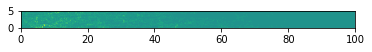

In [46]:
plot(n)

Calling FFC just-in-time (JIT) compiler, this may take some time.


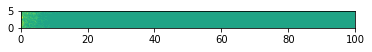

In [47]:
plot(p)

Calling FFC just-in-time (JIT) compiler, this may take some time.


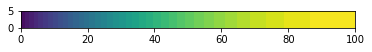

In [48]:
plot(V)

In [26]:
# exact solutions

In [27]:
# f = x^2 * y^2 + x * y
f_exact = Expression("pow(x[0], 2) * pow(x[1], 2) + x[0] * x[1]", degree=4)

# g = x^3 + y^2
g_exact = Expression("pow(x[0], 3) + pow(x[1], 2)", degree=3)

# h = -x^2 + y^3
h_exact = Expression("-pow(x[0], 2) + pow(x[1], 3)", degree=3)

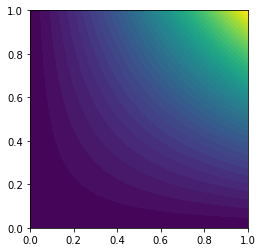

In [28]:
plot(f_exact, mesh = mesh)

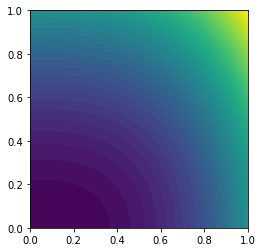

In [29]:
plot(g_exact, mesh = mesh)

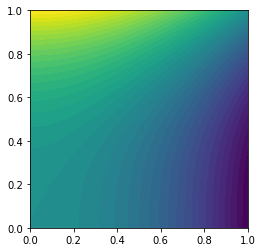

In [30]:
plot(h_exact, mesh = mesh)

In [19]:
vertex_values_f_exact = f_exact.compute_vertex_values(mesh)
vertex_values_g_exact = g_exact.compute_vertex_values(mesh)
vertex_values_f = f.compute_vertex_values(mesh)
vertex_values_g = g.compute_vertex_values(mesh)

error_max_f = np.max(np.abs(vertex_values_f_exact - vertex_values_f))
print("error_max =", error_max_f)
error_max_g = np.max(np.abs(vertex_values_g_exact - vertex_values_g))
print("error_max =", error_max_g)

AttributeError: 'Indexed' object has no attribute 'compute_vertex_values'

In [52]:
dolfin.list_linear_solver_methods()

In [67]:
list_preconditioners() 

NameError: name 'list_preconditioners' is not defined

In [73]:
# list_linear_solver_methods()
# list_krylov_solver_preconditioners()
list_krylov_solver_methods()

In [76]:
solve(F==0, u, bc_array, \
      solver_parameters={'newton_solver': 'gmres',
                         'preconditioner': 'ilu'})

RuntimeError: Parameter newton_solver not found in Parameters object

This integral is missing an integration domain.


UFLException: This integral is missing an integration domain.

In [ ]:
a = dot(grad(v_1), J_n) * dx + dot(grad(v_2), J_p) * dx - v_3 * dot(grad(V), n_vec) * ds + dot(grad(v_3), grad(V)) * dx
     

L = v_1 * (G - R) * dx  - v_2 * (G - R) * dx \
    - v_3 * Constant(e) * (p - n + Constant(N_D) - Constant(N_A))/ Constant(epsr * eps0) * dx


In [88]:
problem = LinearVariationalProblem(a, L, u, bc_array)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to define linear variational problem a(u, v) == L(v) for all v.
*** Reason:  Expecting the left-hand side to be a bilinear form (not rank 1).
*** Where:   This error was encountered inside LinearVariationalProblem.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


In [78]:
solver = NewtonSolver()
solver.parameters["linear_solver"] = "gmres"
#solver.parameters[“linear_solver”][‘maximum_iterations’] = 1000 #error
solver.parameters["preconditioner"] = "ilu"
solver.parameters["maximum_iterations"] = 20